In [29]:
%load_ext autoreload
%autoreload 2

In [31]:
%autoreload

In [26]:
## massey
import pandas as pd
import numpy as np
import itertools
import pickle
import matplotlib.pyplot as plt
from math import ceil 
from tqdm import tqdm
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from pathlib import Path
home = str(Path.home())
import sys
sys.path.insert(0,"%s/sensitivity_study/src"%home)
from experiment import read_raw_pairwise, construct_support_matrix, get_features_from_support, get_target_stability, eval_models
from sensitivity_tests import *
import utilities
sys.path.insert(0,"%s/rankability_toolbox_dev"%home)
import pyrankability

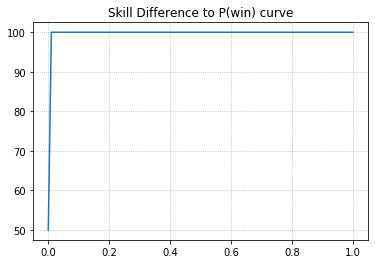

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

ELO_scale = 0.000001

xs = np.linspace(0.0, 1.0, endpoint=True, num=100)
ys = sigmoid(xs/ELO_scale)*100.0

plt.grid(True, axis="both", which="both", linestyle=":")
plt.plot(xs, ys)
plt.title("Skill Difference to P(win) curve")
plt.show()

In [44]:
# This number of games and number of teams were both selected
# to match the NBA regular season
def generate_synth_games(n_games=1230, n_teams=30, n_pts=64, elo_scale=ELO_scale):
    # Columns are team1, team2, points1, points2, date
    df = {
        "team1":[],
        "team2":[],
        "team1_name":[],
        "team2_name":[],
        "team1_select":[],
        "team2_select":[],
        "team1_score":[],
        "team2_score":[],
        "date":[]
    }
    all_teams = range(n_teams)
    all_skills = np.linspace(0.0, 1.0, endpoint=True, num=n_teams)
    for date in range(n_games):
        t1 = date % n_teams
        t2 = t1
        while t2 == t1:
            t2 = random.choice(all_teams)
        # modified to give the better team a 100% chance of winning
        scaled_elo_diff = (all_skills[t1] - all_skills[t2])
        prob_t1_win = 1 if scaled_elo_diff > 0 else 0
        t1_pts = n_pts*np.random.binomial(n=1, p=prob_t1_win)
        t2_pts = n_pts - t1_pts
        df["team1"].append(t1)
        df["team2"].append(t2)
        df["team1_name"].append(str(t1))
        df["team2_name"].append(str(t2))
        df["team1_select"].append(1)
        df["team2_select"].append(1)
        df["team1_score"].append(t1_pts)
        df["team2_score"].append(t2_pts)
        df["date"].append(date)
    return pd.DataFrame(df)

In [45]:
games = []
scales = []
num_tournaments = 75
ELO_scales = [0.2, 0.3, 0.4, 0.5]
for elo_scale in ELO_scales:
    for tourny_num in range(num_tournaments):
        games.append(generate_synth_games())
        scales.append(elo_scale)
games = {idx:game for idx,game in enumerate(games)}
years = list(games.keys())
games[years[-1]]

,team1,team2,team1_name,team2_name,team1_select,team2_select,team1_score,team2_score,date
0,0,26,0,26,1,1,0,64,0
1,1,27,1,27,1,1,0,64,1
2,2,12,2,12,1,1,0,64,2
3,3,0,3,0,1,1,64,0,3
4,4,0,4,0,1,1,64,0,4
...,...,...,...,...,...,...,...,...,...
1225,25,3,25,3,1,1,64,0,1225
1226,26,5,26,5,1,1,64,0,1226
1227,27,8,27,8,1,1,64,0,1227
1228,28,21,28,21,1,1,64,0,1228


In [46]:
games[years[-1]].iloc[:50]

,team1,team2,team1_name,team2_name,team1_select,team2_select,team1_score,team2_score,date
0,0,26,0,26,1,1,0,64,0
1,1,27,1,27,1,1,0,64,1
2,2,12,2,12,1,1,0,64,2
3,3,0,3,0,1,1,64,0,3
4,4,0,4,0,1,1,64,0,4
5,5,18,5,18,1,1,0,64,5
6,6,17,6,17,1,1,0,64,6
7,7,5,7,5,1,1,64,0,7
8,8,11,8,11,1,1,0,64,8
9,9,2,9,2,1,1,64,0,9


In [47]:
frac = .5
year=years[-1]
game_list = list(games[year].index)

game_df = pd.DataFrame({"team1_name":games[year]['team1_name'],
                        "team1_score":games[year]['team1_score'],
                        "team2_name":games[year]['team2_name'],
                        "team2_score":games[year]['team2_score'],
                        "date": games[year]['date']
                       }).sort_values(by='date').drop('date',axis=1)
upper = int(len(game_df)*frac)
game_df_sample = game_df.iloc[:upper,:]
map_func = lambda linked: pyrankability.construct.colley_matrices(linked,direct_thres=0,spread_thres=0,weight_indirect=0)
colleyMatrix_test,b_test = pyrankability.construct.map_vectorized(game_df_sample,map_func)


map_func = lambda linked: pyrankability.construct.massey_matrices(linked,direct_thres=0,spread_thres=0,weight_indirect=0)
masseyMatrix_test,massey_b_test = pyrankability.construct.map_vectorized(game_df_sample,map_func)


teams = pd.Series(list(game_df_sample.team1_name)+list(game_df_sample.team2_name)).unique()

masseyMatrix = pd.DataFrame(np.zeros((len(teams),len(teams))),columns=teams,index=teams)

b = pd.Series(np.zeros((len(teams),)),index=teams)

for i in game_df_sample.index:
    team1ID = game_df_sample.loc[i,"team1_name"]
    team1Score = game_df_sample.loc[i,"team1_score"]

    team2ID = game_df_sample.loc[i,"team2_name"]
    team2Score = game_df_sample.loc[i,"team2_score"]
    
    # Update the Colley matrix and RHS
    if team1Score == team2Score:
        gameWeight = 0 # if you don'include ties and there is a tie, you exclude the game
    else: 
        gameWeight = 1
    
    masseyMatrix.loc[team1ID, team2ID] -= gameWeight
    masseyMatrix.loc[team2ID, team1ID] -= gameWeight

    masseyMatrix.loc[team1ID, team1ID] += gameWeight
    masseyMatrix.loc[team2ID, team2ID] += gameWeight
    
    pointDifferential = gameWeight*abs(team1Score - team2Score)

    if team1Score > team2Score:
        b.loc[team1ID] += pointDifferential
        b.loc[team2ID] -= pointDifferential
    elif team1Score < team2Score:
        b.loc[team1ID] -= pointDifferential
        b.loc[team2ID] += pointDifferential
        
print("n_games == 1230, pre-desingularization sum of games reported by massey:", np.sum(np.diag(masseyMatrix)))
print("pre-desingularization sum of points in b should be 0, is:", np.sum(b))
        
# replace last row with ones and 0 on RHS
masseyMatrix.values[-1,:] = np.ones((1,len(teams)))
b[-1] = 0

"""
## colley
import numpy as np
from math import ceil 

teams = pd.Series(list(game_df_sample.team1_name)+list(game_df_sample.team2_name)).unique()

colleyMatrix = pd.DataFrame(np.zeros((len(teams),len(teams))),columns=teams,index=teams)

b = pd.Series(np.zeros((len(teams),)),index=teams)

for i in game_df_sample.index:
    team1ID = game_df_sample.loc[i,"team1_name"]
    team1Score = game_df_sample.loc[i,"team1_score"]

    team2ID = game_df_sample.loc[i,"team2_name"]
    team2Score = game_df_sample.loc[i,"team2_score"]
    
    # Update the Colley matrix and RHS
    if team1Score == team2Score:
        gameWeight = 0 # if you don'include ties and there is a tie, you exclude the game
    else: 
        gameWeight = 1
    
    colleyMatrix.loc[team1ID, team2ID] -= gameWeight
    colleyMatrix.loc[team2ID, team1ID] -= gameWeight

    colleyMatrix.loc[team1ID, team1ID] += gameWeight
    colleyMatrix.loc[team2ID, team2ID] += gameWeight

    if team1Score > team2Score:
        b.loc[team1ID] += 1/2
        b.loc[team2ID] -= 1/2
    elif team1Score < team2Score:
        b.loc[team1ID] -= 1/2
        b.loc[team2ID] += 1/2
    else:  # whether including ties or not the RHS is not affected
        b.loc[team1ID] += 0; 
        b.loc[team2ID] += 0; 
"""
print("Ranking:", np.argsort(np.linalg.solve(masseyMatrix,b)))
np.linalg.solve(masseyMatrix,b)

/disk/home/egoldfar/rankability_toolbox_dev/pyrankability/construct.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_df["game"] = list(game_df.index)


n_games == 1230, pre-desingularization sum of games reported by massey: 1230.0
pre-desingularization sum of points in b should be 0, is: 0.0
Ranking: [ 0  1  4  2  3  5  6  7  8 10  9 12 14 11 13 16 15 18 17 19 20 22 21 23
 25 24 27 26 28 29]


array([-64.59076718, -60.69302808, -49.73851687, -43.68174969,
       -55.12788247, -40.31176374, -34.03363153, -31.37945565,
       -28.15001549, -16.77501412, -20.21916937,  -3.44771822,
       -11.18200071,  -2.98896228,  -6.95407686,   3.45616123,
         2.99648474,  14.32040459,   6.64192548,  20.69965758,
        22.44020172,  29.49560875,  25.81455247,  29.88105056,
        46.41386642,  44.49256442,  52.13719949,  51.69877204,
        53.04798016,  65.7373226 ])

In [21]:
b

0    -2496.0
1    -2560.0
2    -3008.0
3    -1920.0
4    -1792.0
5    -1920.0
6    -1280.0
7     -960.0
8    -1792.0
9     -192.0
10    -896.0
11    -512.0
12    -576.0
13    -384.0
14    -512.0
15     896.0
16       0.0
17     256.0
18     192.0
19     704.0
20    1408.0
21     896.0
22    2112.0
23    1088.0
24    1856.0
25    2048.0
26    1792.0
27    2368.0
28    2112.0
29       0.0
dtype: float64

In [23]:
masseyMatrix

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,39.0,-1.0,-4.0,-2.0,0.0,0.0,-1.0,-3.0,0.0,-2.0,...,-1.0,0.0,-1.0,-2.0,0.0,-2.0,-1.0,-2.0,-3.0,-1.0
1,-1.0,42.0,0.0,-1.0,-1.0,-1.0,-1.0,-2.0,-3.0,-1.0,...,-2.0,-2.0,-3.0,-2.0,0.0,-1.0,-5.0,0.0,-1.0,-2.0
2,-4.0,0.0,55.0,-4.0,-2.0,-2.0,-3.0,-2.0,-2.0,-2.0,...,-2.0,-1.0,-1.0,0.0,-3.0,-2.0,-6.0,0.0,-2.0,-1.0
3,-2.0,-1.0,-4.0,44.0,-2.0,-1.0,-1.0,-1.0,-2.0,-4.0,...,-3.0,-2.0,0.0,-4.0,-1.0,-2.0,0.0,0.0,-3.0,-1.0
4,0.0,-1.0,-2.0,-2.0,38.0,-1.0,-1.0,-4.0,-1.0,-2.0,...,0.0,-1.0,-1.0,-1.0,-1.0,-2.0,0.0,-1.0,-1.0,0.0
5,0.0,-1.0,-2.0,-1.0,-1.0,40.0,0.0,-1.0,-1.0,-1.0,...,-1.0,-2.0,-1.0,0.0,-2.0,-3.0,0.0,-2.0,-3.0,-5.0
6,-1.0,-1.0,-3.0,-1.0,-1.0,0.0,34.0,0.0,0.0,-4.0,...,-1.0,-1.0,-2.0,-1.0,-2.0,0.0,0.0,-3.0,0.0,-1.0
7,-3.0,-2.0,-2.0,-1.0,-4.0,-1.0,0.0,41.0,-1.0,0.0,...,-1.0,-1.0,0.0,-1.0,0.0,-2.0,-1.0,-3.0,-1.0,-2.0
8,0.0,-3.0,-2.0,-2.0,-1.0,-1.0,0.0,-1.0,48.0,-2.0,...,0.0,-2.0,-3.0,-2.0,-2.0,-2.0,-1.0,-3.0,-2.0,-2.0
9,-2.0,-1.0,-2.0,-4.0,-2.0,-1.0,-4.0,0.0,-2.0,39.0,...,-1.0,-2.0,-4.0,-1.0,-1.0,0.0,0.0,0.0,-2.0,0.0


1183.0